# Import Libraries and Setup
We import the necessary libraries and functions, set up the random seed for reproducibility, and define the paths for the data and model directories.

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR

# Add the path to the 'src' directory to the system's Python path.
# This allows the notebook to import modules from the 'src' directory.
import sys
sys.path.append(os.path.abspath("../src"))

# Import the 'importlib' module, which provides tools for working with modules.
import importlib

# Import the 'functions' module from the 'src' directory.
import functions

# Reload the 'functions' module. This is useful during development
# to ensure that any changes made to 'functions.py' are reflected
# in the notebook without having to restart the kernel.
importlib.reload(functions)

# Import specific functions from the 'functions' module.
# These functions encapsulate the different steps of the machine learning workflow.
from functions import (
    build_pipeline,
    evaluate_model,
    select_features,
    tune_hyperparameters,
    save_model,
    visualize_results,
    load_model
)

# Set a constant random seed value for reproducibility.
# This ensures that any operations involving random number generation
# will produce the same results each time the notebook is run.
RANDOM_STATE = 42

# Load Data

We load the development and evaluation datasets, separate the features and target variables, and create the directories for saving the models.

In [2]:
# Load data
# Load the cleaned development and evaluation datasets from CSV files
# that were created in the data_exploration.ipynb notebook.
dev_df = pd.read_csv('../data/development_final_data.csv')
eval_df = pd.read_csv('../data/evaluation_final_data.csv')

# Separate features and target variables for the development dataset.
# 'bmi' is the target variable we want to predict, so it's separated
# from the features (microbial abundance data).
X_dev, y_dev = dev_df.drop('bmi', axis=1), dev_df['bmi']

# Separate features and target variables for the evaluation dataset.
# This dataset will be used to assess the generalization performance
# of the final models.
X_eval, y_eval = eval_df.drop('bmi', axis=1), eval_df['bmi']

# Directories for models
# Define the directory where trained models will be saved during the process.
models_dir = '../models'
# Define the directory where the final, best-performing models will be stored.
final_models_dir = '../final_models'

# Create the 'models' directory if it doesn't already exist.
# The 'exist_ok=True' argument prevents an error if the directory already exists.
os.makedirs(models_dir, exist_ok=True)

# Create the 'final_models' directory if it doesn't already exist.
# This ensures that the directory is available for saving the final models.
os.makedirs(final_models_dir, exist_ok=True)

# Baseline Models

We train and evaluate the baseline models (ElasticNet, SVR, BayesianRidge) using default hyperparameters and all features. The evaluation results and statistics are printed, and the models are saved.

In [3]:
# 1. Baseline Models
# Initialize an empty dictionary to store the evaluation results for the baseline models.
baseline_results = {}

# Define a dictionary of regression models to be used as baselines.
# Each key is the name of the model, and the value is an instance of the scikit-learn regressor.
regressors = {
    'ElasticNet': ElasticNet(random_state=RANDOM_STATE), # Instantiate ElasticNet with a fixed random state for reproducibility.
    'SVR': SVR(), # Instantiate Support Vector Regression.
    'BayesianRidge': BayesianRidge() # Instantiate Bayesian Ridge Regression.
}

# Iterate through each regressor in the 'regressors' dictionary.
for name, regressor in regressors.items():
    print(f"Training baseline {name}...")
    # Build a pipeline for the current regressor.
    # The 'build_pipeline' function includes scaling (RobustScaler by default)
    # but no feature selection for the baseline models.
    pipeline = build_pipeline(regressor)

    # Evaluate the pipeline on the development data using cross-validation.
    # The 'evaluate_model' function returns a DataFrame of results for each fold
    # and a dictionary of summary statistics (mean, median, confidence intervals).
    results_df, stats = evaluate_model(pipeline, X_dev, y_dev)

    # Store the DataFrame of results in the 'baseline_results' dictionary,
    # with the regressor name as the key.
    baseline_results[name] = results_df

    # Print the summary statistics for the current baseline model.
    print(f"Baseline {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()

    # Save the trained baseline pipeline to the 'models' directory
    # using the regressor name with the suffix '_baseline'.
    save_model(pipeline, f"{name}_baseline", models_dir)

Training baseline ElasticNet...
Baseline ElasticNet statistics:
  RMSE:
    Mean: 4.6922
    Median: 4.2226
    95% CI: (3.4809, 5.9035)
  MAE:
    Mean: 2.9094
    Median: 2.8386
    95% CI: (2.4286, 3.3901)
  R2:
    Mean: -0.3163
    Median: -0.0978
    95% CI: (-0.8365, 0.2039)

✅ Model saved: ../models/ElasticNet_baseline.joblib
Training baseline SVR...
Baseline SVR statistics:
  RMSE:
    Mean: 4.1830
    Median: 4.0412
    95% CI: (3.3507, 5.0152)
  MAE:
    Mean: 2.6857
    Median: 2.6365
    95% CI: (2.5632, 2.8081)
  R2:
    Mean: -0.0238
    Median: -0.0085
    95% CI: (-0.0704, 0.0228)

✅ Model saved: ../models/SVR_baseline.joblib
Training baseline BayesianRidge...
Baseline BayesianRidge statistics:
  RMSE:
    Mean: 4.1618
    Median: 4.0323
    95% CI: (3.2966, 5.0271)
  MAE:
    Mean: 2.7448
    Median: 2.7302
    95% CI: (2.6148, 2.8747)
  R2:
    Mean: -0.0111
    Median: -0.0011
    95% CI: (-0.0309, 0.0086)

✅ Model saved: ../models/BayesianRidge_baseline.joblib


# Feature Selection

We perform feature selection using RFE (or SelectKBest) to reduce the dimensionality of the dataset. The selected features are then used in subsequent steps.

In [4]:
# 2. Feature Selection
# Perform feature selection on the development dataset to reduce dimensionality.
# The 'select_features' function is used here with the Recursive Feature Elimination (RFE) method.
# The 'k' parameter is set to 50, indicating that we want to select the top 50 features.
# You can change the 'method' to 'selectkbest' to use a univariate feature selection method instead.
X_dev_selected, selected_features = select_features(X_dev, y_dev, method='rfe', k=50)

# Apply the same selected features to the evaluation dataset.
# This ensures that the evaluation is performed using the same set of features
# that the model was trained on after feature selection.
X_eval_selected = X_eval[selected_features]

# The 'selected_features' variable now contains a list of the names of the
# 50 most important features identified by RFE on the development data.
# 'X_dev_selected' and 'X_eval_selected' are the feature matrices of the
# development and evaluation sets, respectively, containing only these selected features.

✅ Selected features: ['alistipes_putredinis', 'anaerotruncus_colihominis', 'bacteroides_massiliensis', 'barnesiella_viscericola', 'bifidobacterium_bifidum', 'faecalibacterium_sp._mc_41', 'oscillibacter_valericigenes', 'pseudobacteroides_cellulosolvens', 'pseudoflavonifractor_capillosus', 'roseburia_hominis', 'roseburia_intestinalis', 'ruminiclostridium_thermocellum', 'ruminococcaceae_bacterium_d16', 'ruminococcus_albus', 'ruminococcus_callidus', 'ruminococcus_champanellensis', 'ruminococcus_flavefaciens', 'ruminococcus_sp._dsm_100440', 'sporobacter_termitidis', 'streptococcus_infantarius', 'streptococcus_mitis', 'streptococcus_oralis', 'sutterella_parvirubra', 'thermobaculum_terrenum', 'victivallis_sp._mc_44', 'bacteroides_pectinophilus', 'clostridium_aldenense', 'clostridium_asparagiforme', 'clostridium_bolteae', 'clostridium_celerecrescens', 'clostridium_cellobioparum', 'clostridium_clariflavum', 'clostridium_colinum', 'clostridium_indolis', 'clostridium_leptum', 'clostridium_methylp

# Models with Feature Selection

We train and evaluate the models using the selected features. The evaluation results and statistics are printed, and the models are saved.

In [5]:
# 3. Models with Feature Selection
# Initialize an empty dictionary to store the evaluation results for models trained
# on the selected features.
fs_results = {}

# Iterate through each regressor defined in the 'regressors' dictionary.
for name, regressor in regressors.items():
    print(f"Training {name} with feature selection...")
    # Build a pipeline for the current regressor, this time including feature selection.
    # The 'build_pipeline' function is called with the 'feature_selection' parameter set to 'rfe'
    # and 'k' set to 50, applying RFE to select the top 50 features within the pipeline.
    # Alternatively, you could set 'feature_selection' to 'selectkbest' to use SelectKBest.
    pipeline = build_pipeline(regressor, feature_selection='rfe', k=50)

    # Evaluate the pipeline on the development data containing only the selected features
    # using cross-validation. The 'evaluate_model' function returns the performance metrics.
    results_df, stats = evaluate_model(pipeline, X_dev_selected, y_dev)

    # Store the evaluation results in the 'fs_results' dictionary,
    # with the regressor name as the key.
    fs_results[name] = results_df

    # Print the summary statistics for the current model trained with feature selection.
    print(f"FS {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()

    # Save the trained pipeline (including feature selection) to the 'models' directory
    # using the regressor name with the suffix '_fs' (feature selection).
    save_model(pipeline, f"{name}_fs", models_dir)

Training ElasticNet with feature selection...
FS ElasticNet statistics:
  RMSE:
    Mean: 4.3255
    Median: 3.9814
    95% CI: (3.4954, 5.1555)
  MAE:
    Mean: 2.7560
    Median: 2.7010
    95% CI: (2.4251, 3.0868)
  R2:
    Mean: -0.1073
    Median: 0.0196
    95% CI: (-0.3333, 0.1188)

✅ Model saved: ../models/ElasticNet_fs.joblib
Training SVR with feature selection...
FS SVR statistics:
  RMSE:
    Mean: 4.1671
    Median: 3.9975
    95% CI: (3.2925, 5.0417)
  MAE:
    Mean: 2.6535
    Median: 2.6321
    95% CI: (2.5461, 2.7609)
  R2:
    Mean: -0.0144
    Median: 0.0010
    95% CI: (-0.0628, 0.0341)

✅ Model saved: ../models/SVR_fs.joblib
Training BayesianRidge with feature selection...
FS BayesianRidge statistics:
  RMSE:
    Mean: 4.2785
    Median: 3.9534
    95% CI: (3.4103, 5.1468)
  MAE:
    Mean: 2.7617
    Median: 2.7209
    95% CI: (2.4998, 3.0235)
  R2:
    Mean: -0.0763
    Median: -0.0027
    95% CI: (-0.2442, 0.0916)

✅ Model saved: ../models/BayesianRidge_fs.joblib


# Hyperparameter Tuning

We perform hyperparameter tuning using GridSearchCV to find the best hyperparameters for each model. The tuned models are then trained and evaluated.

In [6]:
# 4. Hyperparameter Tuning
# Initialize an empty dictionary to store the evaluation results for the hyperparameter-tuned models.
tuned_results = {}

# Define a dictionary of parameter grids for each regressor.
# These grids specify the hyperparameter values to be explored during tuning.
param_grids = {
    'ElasticNet': {'regressor__alpha': [0.1, 1.0, 10.0], 'regressor__l1_ratio': [0.1, 0.5, 0.9]},
    'SVR': {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.1, 0.2, 0.5]},
    'BayesianRidge': {'regressor__alpha_1': [1e-6, 1e-5, 1e-4], 'regressor__alpha_2': [1e-6, 1e-5, 1e-4], 'regressor__lambda_1': [1e-6, 1e-5, 1e-4], 'regressor__lambda_2': [1e-6, 1e-5, 1e-4]}
}

# Iterate through each regressor in the 'regressors' dictionary.
for name, regressor in regressors.items():
    print(f"Tuning {name}...")
    # Build a pipeline for the current regressor, including feature selection (RFE with k=50).
    # This ensures that hyperparameter tuning is performed on a pipeline that already includes
    # the feature selection step.
    pipeline = build_pipeline(regressor, feature_selection='rfe', k=50)

    # Tune the hyperparameters of the pipeline using GridSearchCV.
    # 'tune_hyperparameters' function performs cross-validation on the development data
    # to find the best combination of hyperparameters based on the provided parameter grid.
    best_model = tune_hyperparameters(X_dev_selected, y_dev, pipeline, param_grids[name])

    # Evaluate the best tuned model on the development dataset (X_dev_selected).
    # This provides an estimate of how well the tuned model generalizes to unseen data.
    results_df, stats = evaluate_model(best_model, X_dev_selected, y_dev)

    # Store the evaluation results of the tuned model in the 'tuned_results' dictionary.
    tuned_results[name] = results_df

    # Print the summary statistics for the best tuned model.
    print(f"Tuned {name} statistics:")
    for metric, values in stats.items():
        print(f"  {metric}:")
        print(f"    Mean: {values['mean']:.4f}")
        print(f"    Median: {values['median']:.4f}")
        print(f"    95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")
    print()

    # Save the best tuned model to the 'models' directory
    # using the regressor name with the suffix '_tuned'.
    save_model(best_model, f"{name}_tuned", models_dir)

Tuning ElasticNet...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.188e+01, tolerance: 7.487e-01
  model = cd_fast.enet_coordinate_descent(
/root/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e+00, tolerance: 7.487e-01
  model = cd_fast.enet_coordinate_descent(


✅ Best hyperparameters: {'regressor__alpha': 10.0, 'regressor__l1_ratio': 0.9}
✅ Best RMSE: 4.147828891726197
Tuned ElasticNet statistics:
  RMSE:
    Mean: 4.1804
    Median: 4.0575
    95% CI: (3.3066, 5.0542)
  MAE:
    Mean: 2.7805
    Median: 2.7382
    95% CI: (2.6213, 2.9397)
  R2:
    Mean: -0.0198
    Median: -0.0136
    95% CI: (-0.0463, 0.0067)

✅ Model saved: ../models/ElasticNet_tuned.joblib
Tuning SVR...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Best hyperparameters: {'regressor__C': 0.1, 'regressor__epsilon': 0.5}
✅ Best RMSE: 4.146723321155674
Tuned SVR statistics:
  RMSE:
    Mean: 4.1690
    Median: 4.0254
    95% CI: (3.3033, 5.0346)
  MAE:
    Mean: 2.7313
    Median: 2.7188
    95% CI: (2.6116, 2.8511)
  R2:
    Mean: -0.0148
    Median: -0.0092
    95% CI: (-0.0386, 0.0090)

✅ Model saved: ../models/SVR_tuned.joblib
Tuning BayesianRidge...
🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 81 can

# Visualization

We visualize the evaluation results using boxplots to compare the performance of the models at different stages (baseline, feature selection, tuned).

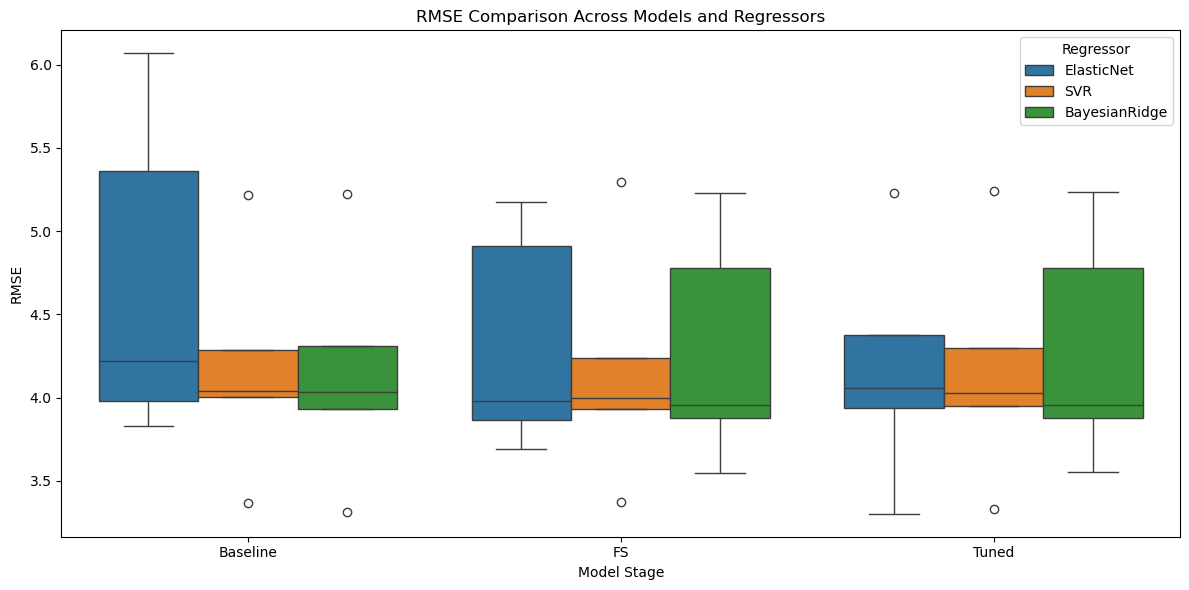

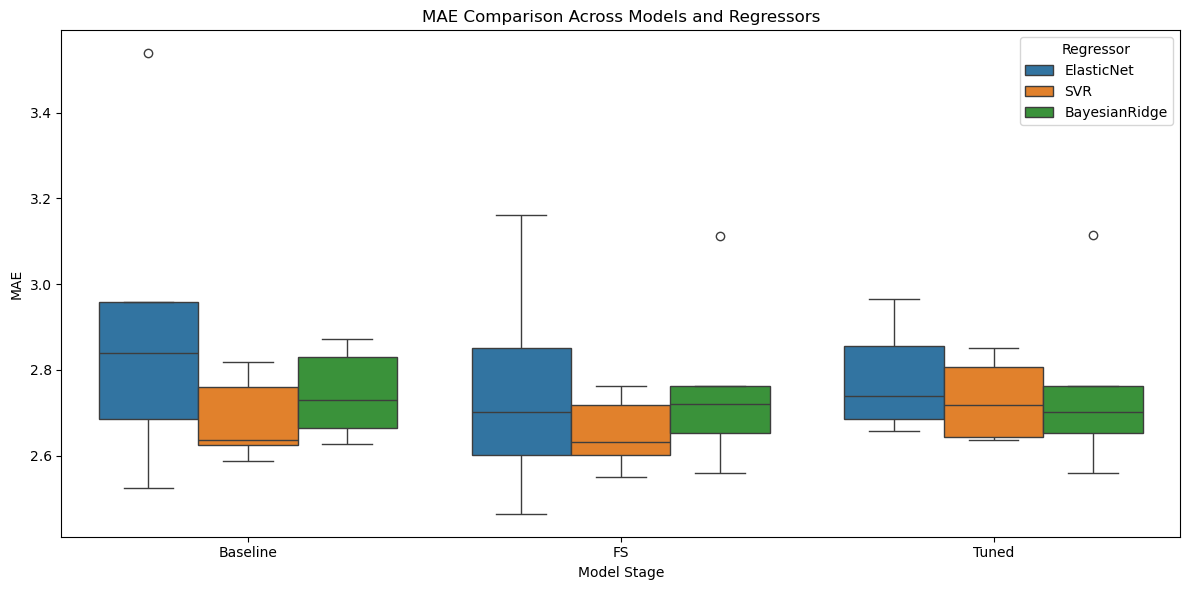

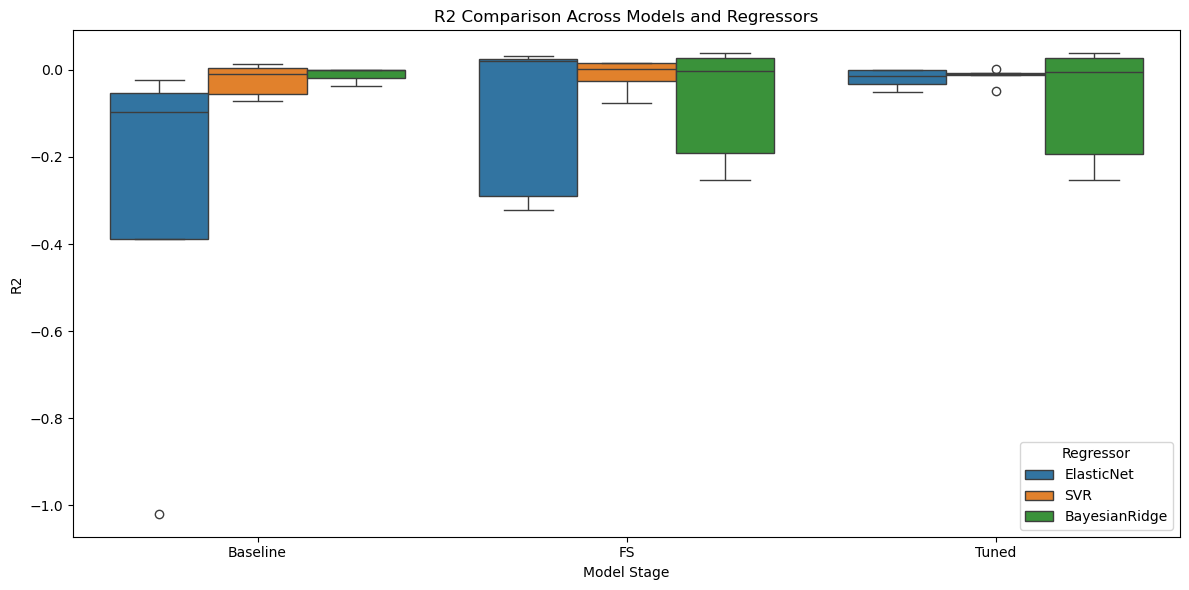

In [7]:
# 5. Visualization
# Call the 'visualize_results' function to generate boxplots comparing the performance
# of the different models across the different stages of the workflow:
# 'Baseline' (models with default parameters),
# 'FS' (models trained on selected features), and
# 'Tuned' (models with optimized hyperparameters).
# The function takes a dictionary where keys are the stage names and values are
# the dictionaries of evaluation results for each regressor at that stage.
visualize_results({
    'Baseline': baseline_results,
    'FS': fs_results,
    'Tuned': tuned_results
})

# This visualization helps in understanding the impact of feature selection and
# hyperparameter tuning on the performance of the different regression models
# (ElasticNet, SVR, BayesianRidge) in terms of RMSE, MAE, and R2.

# Final Models and Comparison

We load the best tuned models for each regressor from the `models` directory, evaluate their performance on the evaluation set, and save them in the `final_models` directory. We then compare the models based on their RMSE to determine the best overall model.

In [8]:
# 6. Final Models and Comparison
# Initialize an empty dictionary to store the final tuned models.
final_models = {}

# Iterate through each regressor name in the 'regressors' dictionary.
for name, regressor in regressors.items():
    print(f"Loading tuned {name}...")
    # Load the best tuned pipeline for the current regressor from the 'models' directory.
    final_pipeline = load_model(f'{models_dir}/{name}_tuned.joblib')
    # Store the loaded pipeline in the 'final_models' dictionary.
    final_models[name] = final_pipeline
    # Save the loaded pipeline to the 'final_models' directory.
    save_model(final_pipeline, name, final_models_dir)

# Evaluate the final tuned models on the evaluation dataset.
final_results = {}
for name, model in final_models.items():
    print(f"Evaluating final {name}...")
    # Evaluate the loaded tuned model on the evaluation data using repeated k-fold
    # cross-validation (n_repeats=5 for more robust evaluation).
    results_df, stats = evaluate_model(model, X_eval_selected, y_eval, n_repeats=5)
    # Store the evaluation statistics in the 'final_results' dictionary.
    final_results[name] = stats

    # Print detailed information about the final tuned model.
    print(f"\nFinal {name} details:")
    print("  Best hyperparameters:")
    # Extract and print the best hyperparameters found during tuning for the current model.
    for key, value in model.named_steps['regressor'].get_params().items():
        print(f"    {key}: {value}")
    print(f"  Selected features: {', '.join(selected_features)}") # Print the features selected by RFE.
    print("  Evaluation results:")
    # Print the mean, median, and 95% confidence intervals for each evaluation metric.
    for metric, values in stats.items():
        print(f"    {metric}:")
        print(f"      Mean: {values['mean']:.4f}")
        print(f"      Median: {values['median']:.4f}")
        print(f"      95% CI: ({values['95% CI'][0]:.4f}, {values['95% CI'][1]:.4f})")

# Compare the performance of the final tuned models based on their RMSE.
print("\nComparing final models:")
best_model_name = None
best_rmse = float('inf')
for name, stats in final_results.items():
    rmse = stats['RMSE']['mean']
    print(f"  {name}: RMSE = {rmse:.4f}")
    # Identify the model with the lowest mean RMSE as the best performing model.
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

# Print the name of the best performing model.
print(f"\nBest model: {best_model_name}")

Loading tuned ElasticNet...
✅ Model saved: ../final_models/ElasticNet.joblib
Loading tuned SVR...
✅ Model saved: ../final_models/SVR.joblib
Loading tuned BayesianRidge...
✅ Model saved: ../final_models/BayesianRidge.joblib
Evaluating final ElasticNet...

Final ElasticNet details:
  Best hyperparameters:
    alpha: 10.0
    copy_X: True
    fit_intercept: True
    l1_ratio: 0.9
    max_iter: 1000
    positive: False
    precompute: False
    random_state: 42
    selection: cyclic
    tol: 0.0001
    warm_start: False
  Selected features: alistipes_putredinis, anaerotruncus_colihominis, bacteroides_massiliensis, barnesiella_viscericola, bifidobacterium_bifidum, faecalibacterium_sp._mc_41, oscillibacter_valericigenes, pseudobacteroides_cellulosolvens, pseudoflavonifractor_capillosus, roseburia_hominis, roseburia_intestinalis, ruminiclostridium_thermocellum, ruminococcaceae_bacterium_d16, ruminococcus_albus, ruminococcus_callidus, ruminococcus_champanellensis, ruminococcus_flavefaciens, ru

# Winner Model

Based on the comparison in the previous step, we train the best performing model (the "winner") on the combined development and evaluation datasets to maximize the amount of training data. This final "winner" model is then saved in the `final_models` directory with the name "winner". This model will be used for final evaluation on an unseen holdout set.

In [9]:
# 7. Winner Model
# Identify the best performing model based on the comparison in the previous step.
winner_model = final_models[best_model_name]

# Train the winning model on the entire available dataset
# (concatenation of the development and evaluation sets) using the selected features.
# This step aims to maximize the model's learning by utilizing all available data.
winner_model.fit(pd.concat([X_dev_selected, X_eval_selected]), pd.concat([y_dev, y_eval]))

# Save the final trained winner model to the 'final_models' directory
# with the filename 'winner'.
save_model(winner_model, 'winner', final_models_dir)

# Print a confirmation message indicating that the notebook execution has finished.
print('✅ Notebook finished.')

✅ Model saved: ../final_models/winner.joblib
✅ Notebook finished.
